In [86]:
import numpy as np
import pandas as pd
import heapq
#from representatives import kMeans # you can use this kMeans in Ex. 3

# Exercise 1

In [2]:
def agglomerativeClustering(D, dist, k=1):
    C = [[i] for i in range(len(D))]

    while len(C) > k:
        distances = np.zeros((len(C), len(C)))
        for i in range(len(C)):
            for j in range(i + 1, len(C)):
                distances[i][j] = dist(D, C[i], C[j])
                distances[j][i] = distances[i][j]

        min_dist = np.inf
        min_i, min_j = None, None

        for i in range(len(C)):
            for j in range(i + 1, len(C)):
                if distances[i][j] < min_dist:
                    min_dist = distances[i][j]
                    min_i, min_j = i, j

        Ci, Cj = C[min_i], C[min_j]
        Cij = []
        Cij.extend(Ci)
        Cij.extend(Cj)

        C.remove(Ci)
        C.remove(Cj)
        C.append(Cij)

    C.sort(key=sortFunction)
    cluster_ids = [-1] * len(D)
    for i, cluster in enumerate(C):
        for point in cluster:
            cluster_ids[point] = i

    return cluster_ids

def sortFunction(elem):
    return min(elem)

In [3]:
def singleLink(D, Ci, Cj):
    min_dist = np.inf
    for i in Ci:
        for j in Cj:
            dist_ij = np.linalg.norm(D[i] - D[j])
            if dist_ij < min_dist:
                min_dist = dist_ij
    return min_dist

In [4]:
def completeLink(D, Ci, Cj):
    max_dist = 0
    for i in Ci:
        for j in Cj:
            dist_ij = np.linalg.norm(D[i] - D[j])
            if dist_ij > max_dist:
                max_dist = dist_ij
    return max_dist

In [5]:
def groupAverage(D, Ci, Cj):
    distance_sum = 0

    D_i = [D[i] for i in Ci]
    D_j = [D[i] for i in Cj]

    for point_i in D_i:
        for point_j in D_j:
            distance_sum += np.linalg.norm(point_i - point_j)

    return distance_sum / (len(D_i) * len(D_j))

In [6]:
def meanDistance(D, Ci, Cj):
    D_i = [D[i] for i in Ci]
    D_j = [D[i] for i in Cj]

    miu_i = np.average(D_i, axis=0)
    miu_j = np.average(D_j, axis=0)

    return np.linalg.norm(miu_j - miu_i)

In [7]:
def ward(D, Ci, Cj):
    D_i = [D[i] for i in Ci]
    D_j = [D[i] for i in Cj]

    miu_i = np.average(D_i, axis=0)
    miu_j = np.average(D_j, axis=0)

    mean_distance = np.linalg.norm(miu_i - miu_j)

    n_i = len(D_i)
    n_j = len(D_j)

    return (((n_i * n_j) / (n_i + n_j)) * (mean_distance**2))

In [13]:
def agglomerativeClusteringLW(D, dist, k=1):
    C = [[i] for i in range(len(D))]

    distances = np.zeros((len(C), len(C)))
    for i in range(len(C)):
        for j in range(i + 1, len(C)):
            distances[i][j] = np.linalg.norm(D[i] - D[j])
            distances[j][i] = distances[i][j]


    while len(C) > k:
        min_dist = np.inf
        min_i, min_j = None, None

        for i in range(len(C)):
            for j in range(i + 1, len(C)):
                if distances[i][j] < min_dist:
                    min_dist = distances[i][j]
                    min_i, min_j = i, j

        Ci, Cj = C[min_i], C[min_j]
        Cij = []
        Cij.extend(Ci)
        Cij.extend(Cj)

        C.remove(Ci)
        C.remove(Cj)
        C.append(Cij)

        n_i = len(Ci)
        n_j = len(Cj)
        n_r = 0

        new_column = []
        for r in range(len(distances)):
            if r != min_i and r != min_j:
                n_r = len(C[r-2])
                a_i, a_j, b, gamma = lanceWilliamsParams(dist, n_i, n_j, n_r)
                
                new_distance = a_i * distances[min_i][r] + a_j * distances[min_j][r] + b * distances[min_i][min_j] + gamma * np.abs(distances[min_i][r] - distances[min_j][r])
                new_column.append(new_distance)

        distances = np.delete(distances, [min_i,min_j], 0)
        distances = np.delete(distances, [min_i,min_j], 1)

        distances = np.insert(distances, len(distances), new_column, 0)
        new_column.append(0)
        distances = np.insert(distances, (len(distances)-1), new_column, 1)


    C.sort(key=sortFunction)
    cluster_ids = [-1] * len(D)
    for i, cluster in enumerate(C):
        for point in cluster:
            cluster_ids[point] = i

    return cluster_ids

def sortFunction(elem):
    return min(elem)

def lanceWilliamsParams(dist, n_i, n_j, n_r):
    if dist == 'single':
        return (1/2, 1/2, 0, -(1/2))
    elif dist == 'complete':
        return (1/2, 1/2, 0, 1/2)
    elif dist == 'groupavg':
        return ((n_i/(n_i+n_j)), (n_j/(n_i+n_j)), 0, 0)
    elif dist == 'meandist':
        return ((n_i/(n_i+n_j)), (n_j/(n_i+n_j)), (-(n_i*n_j)/((n_i+n_j)**2)), 0)
    elif dist == 'ward':
        return (((n_i+n_r)/(n_i+n_j+n_r)), ((n_j+n_r)/(n_i+n_j+n_r)), (-(n_r)/(n_i+n_j+n_r)), 0)

In [15]:
from sklearn.decomposition import PCA

'''
  Tries to make clustering c2 equal to clustering c1 by renaming the cluster names.
  If the clusterings are effectively equivalent, the output will be equal to c1.
'''
def try_unification(c1, c2):
    v1 = list(np.unique(c1))
    v2 = list(np.unique(c2))
    new_vals = []
    if len(c1) != len(c2):
        print("Cannot unify clusterings of different lengths!")
        return None
    if len(v1) != len(v2):
        print("Cannot unify clusterings of different numbers of clusters!")
        return None
    
    
    # use different symbols for clusterings
    i = 0
    for v in v2:
        c = "v" + str(i)
        while c in v1:
            i +=1
            c = "v" + str(i)
        new_vals.append(c)
        i += 1
    c_new = [new_vals[v2.index(i)] for i in c2]
    
    # replace occurrences
    targets = []
    for symbol in new_vals:
        first_index = c_new.index(symbol)
        replace_symbol = None
        for v in c1:
            if not v in targets:
                replace_symbol = v
                break
        if replace_symbol in targets:
            print("Warning: No unification possible, the symbol " + replace_symbol + " has already been addressed before!")
            return None
        
        c_new = [replace_symbol if v == symbol else v for v in c_new]
        targets.append(replace_symbol)
    return c_new

# Test Complete Link on Iris (PCA)
dfIris = pd.read_csv("iris.csv")
DIris = PCA(n_components=2).fit_transform(dfIris.values[:,:4])
labelsIris = list(pd.unique(dfIris["species"]))
C_perfect = np.array([labelsIris.index(l) for l in dfIris["species"]])
C_iris = np.array(try_unification(C_perfect, agglomerativeClustering(DIris, completeLink, k=3)))
M_expected = np.array([[50, 0, 0], [0, 14, 49], [0, 36, 1]]) # according to slide 13
for i in range(3):
    cond1 = C_iris == i
    for j in range(3):
        cond2 = C_perfect == j
        cnt_combo = np.count_nonzero(cond1 & cond2)
        print(labelsIris[i] + "/" + labelsIris[j] + ": " + ("OK" if cnt_combo == M_expected[i,j] else "FAILED. Expected " + str(M_expected[i,j]) + " but saw " + str(cnt_combo)))

# Test Coincidence of Standard and Lance-Williams
for D in [DIris, pd.get_dummies(pd.read_csv("Mall_Customers.csv")).values]:
    for pair in [("single", singleLink), ("complete", completeLink), ("groupavg", groupAverage), ("ward", ward)]:
        C_ac = np.array(agglomerativeClustering(D, pair[1], k=3))
        C_aclw = np.array(try_unification(C_ac, agglomerativeClusteringLW(D, pair[0], k=3)))
        mismatches = C_ac != C_aclw
        print(pair[0] + (" OK" if np.count_nonzero(mismatches) == 0 else (" FAILED. Difference in positions: " + str(np.where(mismatches)[0]) + ": " + str(C_ac[mismatches]) + " vs " + str(C_aclw[mismatches]))))

setosa/setosa: OK
setosa/versicolor: OK
setosa/virginica: OK
versicolor/setosa: OK
versicolor/versicolor: OK
versicolor/virginica: OK
virginica/setosa: OK
virginica/versicolor: OK
virginica/virginica: OK
single OK
complete OK
groupavg OK
ward FAILED. Difference in positions: [ 77 110 134]: [2 2 2] vs [1 1 1]
single OK
complete OK
groupavg OK
ward FAILED. Difference in positions: [124 132 142]: [2 2 2] vs [1 1 1]


# Exercise 2

## 1)

In [24]:
df_mall = pd.read_csv("Mall_Customers.csv")
df_mall['Gender'] = df_mall['Gender'].apply(lambda x: 1 if x == 'Female' else 0)
D = df_mall.to_numpy()

In [29]:
single_mall = agglomerativeClustering(D,singleLink,k=5)

In [30]:
single_mall_lw = agglomerativeClusteringLW(D,'single',k=5)

In [31]:
print("Are both calculations the same?")
print(single_mall == single_mall_lw)

Are both calculations the same?
True


In [32]:
groupavg_mall = agglomerativeClustering(D,groupAverage,k=5)

In [33]:
groupavg_mall_lw = agglomerativeClusteringLW(D,'groupavg',k=5)

In [34]:
print("Are both calculations the same?")
print(groupavg_mall == groupavg_mall_lw)

Are both calculations the same?
True


As we can see, we got two very similar results with both our tests. During the first one, where we used single link, we can see that, without the LW formula, we got a runtime of about 11.5s, while the same calculation took a mere 0.3s while using the formula. As we can see, the results were the same, so there's no quality trade off.

As for the second test, using group average, we can see something similar. It took almost 13s for the algorithm to run without the LW formula, and only 0.3s using it.

The conclusion and interpretation is obvious. It is much more efficent to only update our distance matrix using the Lance-Williams formula than calculate it over and over again using the functions for every metric.

# 2)

Since we want to maximize score(P) based on P, we will ignore the outer sum, since, no matter which value for P we choose, it will always sum over the same clusters.

Taking this into account, we can see that maximizing the square root of the sum that goes over every value in P will be the same as maximizing the sum itself. This is due to the incremental property of the square root function; no matter for how long it goes, it is strictly incremental, since it will return larger and larger values the larger its argument becomes.

Now, given the independence between the dimensions picked and the clusters the sum goes over, we can rearrange the sum so that the outer sum goes inside the inner one, now that the inner one is no longer restricted by the square root.

As such, we can see that maximizing the original formula for score(P) is the same as maximizing the second formula, and much faster, since we do not need to wait for the square root of the inner sum.

## 3)

In [66]:
a = [[1,2],[3,4]]
np.average(a, axis=0)

b = [[] for x in range(4)]
b[3].append([1,4])
b[3].append([2,4])
b[3].append([3,4])
b[3].append([4,4])

np.average(b[3], axis=0)

array([2.5, 4. ])

In [94]:
def getBestProjection(A, C, targetdims=2):
    
    cluster_mean_list = []
    clusters_set = list(set(C))

    data = [[] for x in range(len(clusters_set))]

    for i, point in enumerate(A):
        cluster_index = clusters_set.index(C[i])
        data[cluster_index].append(point)

    for cluster_data in data:
        cluster_mean_list.append(np.average(cluster_data, axis=0))

    scores = []
    for att in range(A.shape[1]):
        score = 0
        for i in range(len(cluster_mean_list)):
            for j in range(i + 1, len(cluster_mean_list)):
                score += (cluster_mean_list[i][att] - cluster_mean_list[j][att])**2
        scores.append(score)

    max_values = heapq.nlargest(targetdims, scores)

    best_dims = []
    for element in max_values:
        best_dims.append(scores.index(element))
        
    return best_dims


In [95]:
df_riddle = pd.read_csv('riddle.csv')
D = df_riddle.to_numpy()

C = agglomerativeClusteringLW(D, 'single', k=4)
print('done')

getBestProjection(D,C,5)

done
86.30827896914536
19.789933854814517
2.3827436781439655


[598, 42, 231, 762, 914]

## 4)

AttributeError: 'NoneType' object has no attribute 'fit'

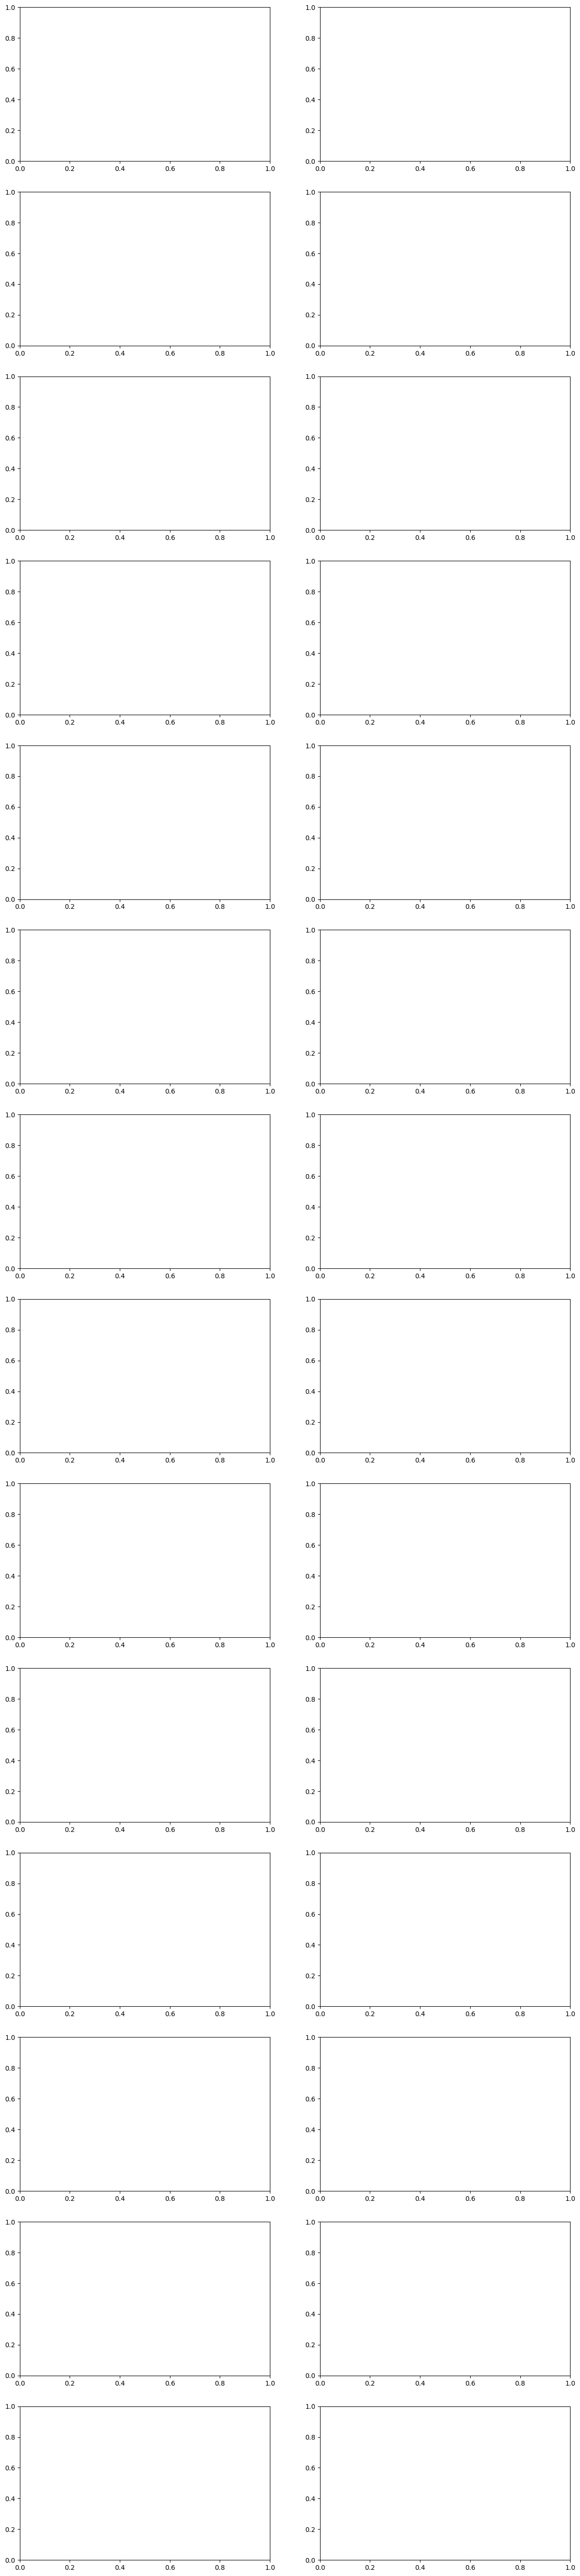

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans


df_mall = pd.read_csv("Mall_Customers.csv", header=0)
df_mall['Gender'] = df_mall['Gender'].apply(lambda x: 1 if x == 'Female' else 0)
df_ridd = pd.read_csv("riddle.csv")
df_spir = pd.read_csv("spiral.csv", delimiter="\t")


def plot_subfigures(X, k, methods):
    fig, axes = plt.subplots(len(methods), 2, figsize=(15, 5 * len(methods)))
    
    for i, method in enumerate(methods):
        
        if method == 'K-Means':
            clusterer = KMeans(n_clusters=k, random_state=0)
        else:
            clusterer = agglomerativeClusteringLW(X, method.lower(), k)
        
        clusterer.fit(X)
        labels = clusterer.labels_
                
        
        axes[i, 0].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
        axes[i, 0].set_title(f'{method} {k} - 2D Projection')
        
        
        ax = fig.add_subplot(5, 2, i*2+2, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis', alpha=0.5)
        ax.set_title(f'{method} {k} - 3D Projection')
        
    plt.tight_layout()
    plt.show()


X_mall = df_mall.iloc[:, 2:].values
plot_subfigures(X_mall, 5, 'Mall_Customers')


X_ridd = df_ridd.values
plot_subfigures(X_ridd, 5, 'riddle')


X_spir = df_spir.values
plot_subfigures(X_spir, 3, 'spiral')
